In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset, get_dataset_split_names, DatasetDict
from tqdm import tqdm

sns.set_color_codes("colorblind")
sns.set_theme(style="darkgrid")
sns.set_context("talk")
tqdm.pandas()

# set font to times new roman for plots
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

/Users/kyle/miniconda3/envs/memorization/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Datasets

In [2]:
split_sample_size = None
label_title_padding = 10
study_pile = False
RECITATION_THRESHOLD = 2

In [3]:
memories_path = "usvsnsp/generation-semantic-filters"
intermediate_path = "usvsnsp/generation-semantic-intermediate-filters"
memories_dataset = DatasetDict()
pile_dataset = DatasetDict()
splits = [split for split in get_dataset_split_names(memories_path) if "deduped" in split] + get_dataset_split_names(intermediate_path)
splits = [split for split in splits if "deduped" in split]
print(splits)

['pile_deduped_1.4b', 'memories_deduped_410m', 'memories_deduped_1.4b', 'memories_deduped_6.9b', 'memories_deduped_1b', 'pile_deduped_410m', 'pile_deduped_2.8b', 'pile_deduped_160m', 'memories_deduped_12b', 'pile_deduped_6.9b', 'pile_deduped_1b', 'memories_deduped_70m', 'memories_deduped_2.8b', 'pile_deduped_12b', 'memories_deduped_160m', 'pile_deduped_70m', 'memories_deduped_12b.43000', 'memories_deduped_12b.103000', 'memories_deduped_12b.83000', 'memories_deduped_12b.63000', 'memories_deduped_12b.123000', 'memories_deduped_12b.23000']


In [4]:
print("Loading datasets...")
print(f"Split sample size: {split_sample_size}")

for split in tqdm(splits):
    model = split.split("_")[-1]
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() else "Final"
    formatted_split_name = split.replace("memories_", "").replace("deduped_", "deduped.").replace("pile_", "")
    dataset_path = memories_path if checkpoint == "Final" else intermediate_path
    if "memories" in split: 
        # continue # Don't load memories since they're unnecessary for the first part of the analysis
        memories_dataset[formatted_split_name] = load_dataset(dataset_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)
    else:
        continue
        pile_dataset[formatted_split_name] = load_dataset(dataset_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)

display(memories_dataset)
display(pile_dataset)

Loading datasets...
Split sample size: None


100%|██████████| 22/22 [05:30<00:00, 15.04s/it]


DatasetDict({
    deduped.410m: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
        num_rows: 811040
    })
    deduped.1.4b: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
    

DatasetDict({
    
})

In [5]:
split_to_param_count = {
    "70m": 70000000,
    "160m": 160000000,
    "410m": 410000000,
    "1b": 1000000000,
    "1.4b": 1400000000,
    "2.8b": 2800000000,
    "6.9b": 6900000000,
    "12b": 12000000000,
}

In [6]:
def get_frame_from_split(dataset, split_name, is_pile_sample):
    current_frame = dataset[split].to_pandas()
    current_frame.drop(columns=columns_to_drop, inplace=True)
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() and len(split.split(".")) != 2 else "Final"
    current_frame["Checkpoint"] = checkpoint
    model = split.split("deduped")[-1][1:] if checkpoint == "Final" else split.split(".")[-2]
    current_frame["Model"] = model
    current_frame["Param Count"] = split_to_param_count[current_frame["Model"].iloc[0]]
    current_frame["Deduped"] = "deduped" in split
    current_frame["Memorized"] = current_frame["memorization_score"] >= 1
    current_frame["IsPileSample"] = is_pile_sample
    return current_frame


columns_to_drop = ["frequencies", "tokens", "text"]
combined_dataframe = None
for split in tqdm(memories_dataset, desc="Loading Memories"):
    current_frame = get_frame_from_split(memories_dataset, split, False)
    if combined_dataframe is None:
        combined_dataframe = current_frame
    else:
        combined_dataframe = pd.concat([combined_dataframe, current_frame])

for split in tqdm(pile_dataset, desc="Loading Pile"):
    current_frame = get_frame_from_split(pile_dataset, split, True)
    combined_dataframe = pd.concat([combined_dataframe, current_frame])

combined_dataframe = combined_dataframe.sort_values("Param Count")
# display(combined_dataframe.shape)
# display(combined_dataframe.columns)
combined_dataframe

Loading Memories: 100%|██████████| 14/14 [00:29<00:00,  2.11s/it]
Loading Pile: 0it [00:00, ?it/s]


,sequence_id,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,p75_frequency,...,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,Checkpoint,Model,Param Count,Deduped,Memorized,IsPileSample
311692,76369286,True,False,3,2965935634,9.619414e+08,1466086,26718143.5,3396213,2965935634,...,0.901367,1.762004,1.028962,1.813036,Final,70m,70000000,True,True,False
274304,101528653,False,False,126590,11740996961,2.183443e+09,2535454,397855078.0,24463239,1480613645,...,0.828125,2.405067,1.001652,2.409041,Final,70m,70000000,True,True,False
274303,101488489,False,False,12551,11740996961,2.955296e+09,605886,223388936.0,16400100,4201626736,...,0.895020,2.173179,1.022547,2.222178,Final,70m,70000000,True,True,False
274302,101355445,False,False,39601,11740996961,1.373194e+09,1033836,87048161.0,10406762,365616254,...,0.788574,3.974078,1.012878,4.025258,Final,70m,70000000,True,True,False
274301,101319862,False,False,40819,11740996961,3.075328e+09,1317065,573756779.0,12931579,4201626736,...,0.823242,1.956711,1.012603,1.981370,Final,70m,70000000,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325534,43193238,False,False,609181,11740996961,2.319468e+09,1612787,24613500.5,5114476,939268059,...,NaN,NaN,NaN,NaN,43000,12b,12000000000,True,True,False
325533,43187425,False,False,226,11740996961,2.506770e+09,344343,108487617.0,5756465,1480613645,...,NaN,NaN,NaN,NaN,43000,12b,12000000000,True,True,False
325532,43165692,False,False,3504,11740996961,1.040303e+09,351874,171363758.0,7462193,304221700,...,NaN,NaN,NaN,NaN,43000,12b,12000000000,True,True,False
325542,43328930,False,False,6731,11740996961,1.400083e+09,711305,90651872.0,11201675,816247750,...,NaN,NaN,NaN,NaN,43000,12b,12000000000,True,True,False


## Assign Examples to Taxonomy

In [7]:
def get_category(row):
    if row["Memorized"] == False:
        return "Not Memorized"
    if row["sequence_duplicates"] >= RECITATION_THRESHOLD:
        return "Recitation"
    if row["is_incrementing"] or row["is_repeating"]:
        return "Reconstruction"

    return "Recollection"

combined_dataframe["category"] = combined_dataframe.progress_apply(lambda row: get_category(row), axis=1)
combined_dataframe.value_counts(["Model", "Checkpoint", "category"])

100%|██████████| 13510441/13510441 [00:36<00:00, 374239.21it/s]


Model  Checkpoint  category      
12b    Final       Recitation        1807784
6.9b   Final       Recitation        1624577
12b    123000      Recitation        1510751
2.8b   Final       Recitation        1309226
12b    103000      Recitation        1154194
1.4b   Final       Recitation        1013361
1b     Final       Recitation         999304
12b    83000       Recitation         821928
410m   Final       Recitation         784715
12b    63000       Recitation         564663
160m   Final       Recitation         562743
70m    Final       Recitation         400631
12b    43000       Recitation         346428
       23000       Recitation         157879
       Final       Recollection        58071
6.9b   Final       Recollection        50491
12b    123000      Recollection        48682
2.8b   Final       Recollection        40885
12b    103000      Recollection        37608
1.4b   Final       Recollection        30167
1b     Final       Recollection        28825
12b    83000       Re

## Plot Graphs

### Figure: Count and Memories by Taxonomy Across Time and Scale

In [8]:
combined_memories_dataframe = combined_dataframe[combined_dataframe["IsPileSample"] == False]
combined_memories_dataframe

,sequence_id,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,p75_frequency,...,prompt_perplexity,generation_perplexity,sequence_perplexity,Checkpoint,Model,Param Count,Deduped,Memorized,IsPileSample,category
311692,76369286,True,False,3,2965935634,9.619414e+08,1466086,26718143.5,3396213,2965935634,...,1.762004,1.028962,1.813036,Final,70m,70000000,True,True,False,Recitation
274304,101528653,False,False,126590,11740996961,2.183443e+09,2535454,397855078.0,24463239,1480613645,...,2.405067,1.001652,2.409041,Final,70m,70000000,True,True,False,Recitation
274303,101488489,False,False,12551,11740996961,2.955296e+09,605886,223388936.0,16400100,4201626736,...,2.173179,1.022547,2.222178,Final,70m,70000000,True,True,False,Recitation
274302,101355445,False,False,39601,11740996961,1.373194e+09,1033836,87048161.0,10406762,365616254,...,3.974078,1.012878,4.025258,Final,70m,70000000,True,True,False,Recitation
274301,101319862,False,False,40819,11740996961,3.075328e+09,1317065,573756779.0,12931579,4201626736,...,1.956711,1.012603,1.981370,Final,70m,70000000,True,True,False,Recitation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325534,43193238,False,False,609181,11740996961,2.319468e+09,1612787,24613500.5,5114476,939268059,...,NaN,NaN,NaN,43000,12b,12000000000,True,True,False,Recitation
325533,43187425,False,False,226,11740996961,2.506770e+09,344343,108487617.0,5756465,1480613645,...,NaN,NaN,NaN,43000,12b,12000000000,True,True,False,Recitation
325532,43165692,False,False,3504,11740996961,1.040303e+09,351874,171363758.0,7462193,304221700,...,NaN,NaN,NaN,43000,12b,12000000000,True,True,False,Recitation
325542,43328930,False,False,6731,11740996961,1.400083e+09,711305,90651872.0,11201675,816247750,...,NaN,NaN,NaN,43000,12b,12000000000,True,True,False,Recitation


In [15]:
# Create plot for data across 
counts_frame_scale = combined_memories_dataframe[combined_memories_dataframe["Checkpoint"] == "Final"].value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
counts_frame_scale.to_csv(f"final_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(counts_frame_scale)

intermediate_frame = combined_memories_dataframe[(combined_memories_dataframe["Checkpoint"] != "Final") & (combined_memories_dataframe["Model"] == "12b")]
sorted_checkpoints = sorted(intermediate_frame["Checkpoint"].unique(), key=lambda x: int(x))

counts_frame_time = intermediate_frame.value_counts(["Checkpoint", "category"]).unstack().reindex(sorted_checkpoints)
counts_frame_time.to_csv(f"intermediate_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(counts_frame_time)

category,Recitation,Recollection,Reconstruction
Param Count,,,
70000000,400631,7789,3028
160000000,562743,14331,4126
410000000,784715,21802,4523
1000000000,999304,28825,4743
1400000000,1013361,30167,4576
2800000000,1309226,40885,5105
6900000000,1624577,50491,5228
12000000000,1807784,58071,5361


category,Recitation,Recollection,Reconstruction
Checkpoint,,,
23000,157879,4795,744
43000,346428,11012,1423
63000,564663,18167,2237
83000,821928,27118,3022
103000,1154194,37608,3776
123000,1510751,48682,4622


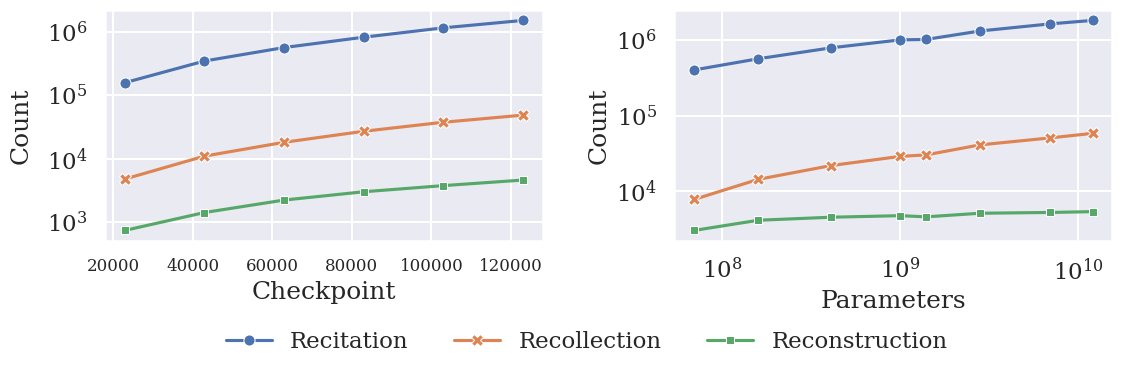

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(13, 3))

# set figure 1
# first figure is a line plot of the counts of each category for across intermediate checkpoints

sns.lineplot(ax=axes[0], data=counts_frame_time, dashes=False, markers=True, markersize=8)

# rotate x axis labels
# axes[0].tick_params(axis='x', rotation=20)

# make x labels smaller
axes[0].tick_params(axis='x', labelsize=12)

# Add y label for Count
axes[0].set_ylabel("Count", labelpad=label_title_padding)

# add padding for labels
fig.subplots_adjust(wspace=0.2)

# make x and y axis log scale
axes[0].set_yscale("log")

# # have a common legend for both plots centered below the figure. No legend box
axes[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.3), ncol=4, frameon=False)

# set figure 2
# the second figure is a line plot of the counts of each category across parameter count

sns.lineplot(ax=axes[1], data=counts_frame_scale, dashes=False, markers=True, markersize=8)

# make x and y axis log scale
axes[1].set_xscale("log")
axes[1].set_yscale("log")

# Set x label to "Parameters"
axes[1].set_xlabel("Parameters")

# Add y label for Count
axes[1].set_ylabel("Count")

# remove legend
axes[1].legend().remove()

# add padding for labels
fig.subplots_adjust(wspace=0.30)

fig.savefig(f"categories_counts_across_time+scale_recitation={RECITATION_THRESHOLD}.pdf", bbox_inches="tight")



### Figure: Percents and Memories by Taxonomy Across Time and Scale

In [11]:
counts_frame = combined_memories_dataframe.value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
display(counts_frame)

category,Recitation,Recollection,Reconstruction
Param Count,,,
70000000,400631,7789,3028
160000000,562743,14331,4126
410000000,784715,21802,4523
1000000000,999304,28825,4743
1400000000,1013361,30167,4576
2800000000,1309226,40885,5105
6900000000,1624577,50491,5228
12000000000,6363627,205453,21185


In [12]:
sorted_checkpoints = [23000, 43000, 63000, 83000, 103000, 123000]
assert len(sorted_checkpoints) + 1 == len(combined_memories_dataframe[(combined_memories_dataframe["Model"] == "12b") & (combined_memories_dataframe["Deduped"] == True)]["Checkpoint"].unique())

all_percents_time = []
for checkpoint in tqdm(sorted_checkpoints):
    model_examples = combined_memories_dataframe[combined_memories_dataframe["Checkpoint"] == checkpoint]
    model_percents = model_examples.value_counts("category", normalize=True).to_dict()
    for category in model_percents:
        all_percents_time.append({
            "Checkpoint": checkpoint,
            "category": category,
            "percent": model_percents[category],
        })

percents_frame_time = pd.DataFrame(all_percents_time).pivot(index="Checkpoint", columns="category", values="percent").reindex(sorted_checkpoints)
percents_frame_time.to_csv(f"percents_frame_time_recitation={RECITATION_THRESHOLD}.csv")
display(percents_frame_time)

100%|██████████| 6/6 [00:02<00:00,  2.82it/s]


category,Recitation,Recollection,Reconstruction
Checkpoint,,,
23000,0.966105,0.029342,0.004553
43000,0.965349,0.030686,0.003965
63000,0.965125,0.031051,0.003823
83000,0.964627,0.031826,0.003547
103000,0.965386,0.031456,0.003158
123000,0.965919,0.031126,0.002955


In [13]:
all_percents_scale = []
for param_count in tqdm(split_to_param_count.values()):
    model_examples = combined_memories_dataframe[combined_memories_dataframe["Param Count"] == param_count]
    model_percents = model_examples.value_counts("category", normalize=True).to_dict()
    for category in model_percents:
        all_percents_scale.append({
            "Model": model_examples["Model"].unique()[0],
            "Param Count": param_count,
            "category": category,
            "percent": model_percents[category],
        })

percents_frame_scale = pd.DataFrame(all_percents_scale).pivot(index="Model", columns="category", values="percent").reindex(split_to_param_count.keys())
percents_frame_scale.to_csv(f"percents_frame_scale_recitation={RECITATION_THRESHOLD}.csv")
display(percents_frame_scale)

100%|██████████| 8/8 [00:01<00:00,  5.00it/s]


category,Recitation,Recollection,Reconstruction
Model,,,
70m,0.973710,0.018931,0.007359
160m,0.968243,0.024658,0.007099
410m,0.967542,0.026882,0.005577
1b,0.967500,0.027908,0.004592
1.4b,0.966852,0.028782,0.004366
2.8b,0.966064,0.030169,0.003767
6.9b,0.966840,0.030049,0.003111
12b,0.965610,0.031175,0.003215


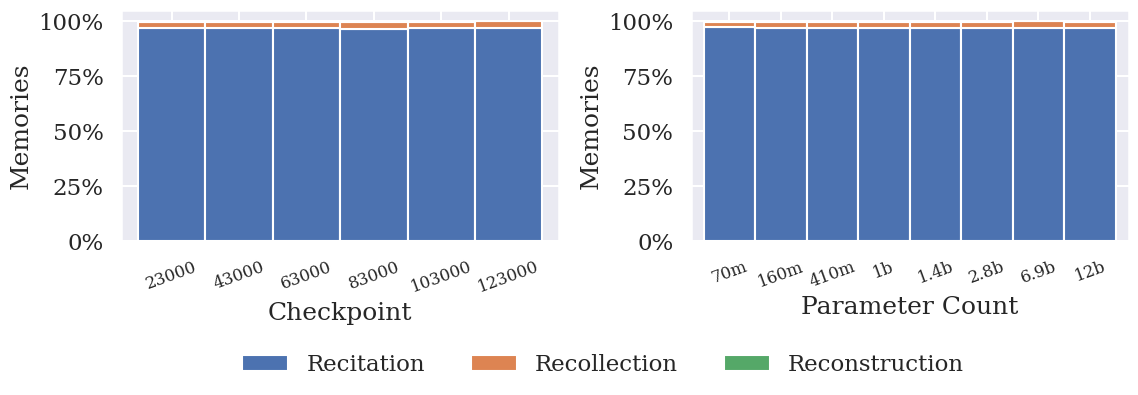

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(13, 3))
plots = [
    (percents_frame_time, axes[0]),
    (percents_frame_scale, axes[1])
]

for idx, (data, ax) in enumerate(plots):
    data.plot.bar(
        stacked=True,
        ax=ax,
        rot=0,
        width=1,
        ylabel="Memories",
    )

    if idx == 0:
        ax.set_xlabel("Checkpoint")
    else:
        ax.set_xlabel("Parameter Count")
    
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
    ax.tick_params(axis='x', rotation=20, labelsize=12)
    ax.get_legend().remove()

# Adjusting subplot parameters
fig.subplots_adjust(wspace=0.30)

# Common legend configuration
axes[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.4), ncol=4, frameon=False)

# Save the figure
fig.savefig(f"categories_percents_across_time+scale_recitation={RECITATION_THRESHOLD}.pdf", bbox_inches="tight")


## Figure: Combined Counts + Percents Plot

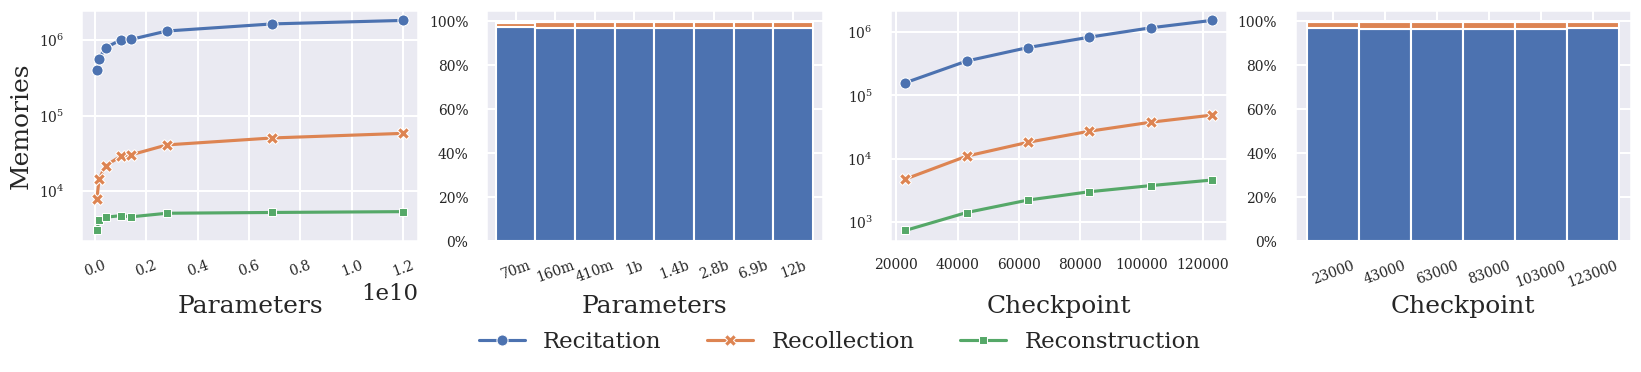

In [57]:
# Single row with four plots. Plot ordering is counts across scale, percents across scale, counts across time, percents across time
fig, axes = plt.subplots(1, 4, figsize=(20, 3))

# set figure 1
sns.lineplot(ax=axes[0], data=counts_frame_scale, dashes=False, markers=True, markersize=8)
axes[0].tick_params(axis='x', rotation=20, labelsize=10)
axes[0].set_yscale("log")
axes[0].tick_params(axis='y', labelsize=10)
axes[0].set_ylabel("Memories")
axes[0].set_xlabel("Parameters")
axes[0].legend(loc='upper center', bbox_to_anchor=(2.25, -0.3), ncol=4, frameon=False)

# set figure 2
percents_frame_scale.plot.bar(
    stacked=True,
    ax=axes[1],
    rot=0,
    width=1,
)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
axes[1].tick_params(axis='x', rotation=20, labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)
axes[1].set_xlabel("Parameters")
axes[1].get_legend().remove()

# set figure 3
sns.lineplot(ax=axes[2], data=counts_frame_time, dashes=False, markers=True, markersize=8)
axes[2].set_yscale("log")
axes[2].tick_params(axis='x', labelsize=10)
axes[2].tick_params(axis='y', labelsize=10)
axes[2].set_xlabel("Checkpoint")
axes[2].legend().remove()

# set figure 4
percents_frame_time.plot.bar(
    stacked=True,
    ax=axes[3],
    rot=0,
    width=1,
)
axes[3].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
axes[3].tick_params(axis='x', rotation=20, labelsize=10)
axes[3].tick_params(axis='y', labelsize=10)
axes[3].get_legend().remove()

# make all the x labels have the same height
fig.align_xlabels()

# Save the figure
fig.savefig(f"categories_counts_percents_across_time+scale_recitation={RECITATION_THRESHOLD}.pdf", bbox_inches="tight")